# ChronoTranscriber Evaluation: CER & WER Analysis

This notebook evaluates transcription quality across multiple transcription systems (local OCR and multiple LLM providers) using edit-distance–based accuracy metrics computed against manually corrected ground truth.

The primary evaluation outputs are:
- **Character Error Rate (CER)**: edit distance at the character level, divided by the number of reference characters.
- **Word Error Rate (WER)**: edit distance at the word level, divided by the number of reference words.

## Evaluation Method
The evaluation is performed **page-by-page** using the temporary JSONL files produced by the ChronoTranscriber pipeline. Page-level evaluation is preferred over comparing final exported plain-text files because it:
- Avoids penalizing downstream whitespace or post-processing differences that do not reflect transcription quality.
- Preserves page boundaries to support error localization and qualitative inspection.
- Enables fairer comparisons across models when outputs vary in formatting.

The metrics implementation distinguishes:
- **Overall metrics**: computed on the full text (including markup and page markers if present).
- **Content-only metrics**: computed after removing formatting artifacts to focus on raw text recognition.
- **Formatting metrics** (available in the underlying metric implementation): separate accounting for page markers and common Markdown constructs.

## Models Evaluated
| Provider | Model | `model_id` | Reasoning |
|----------|-------|-----------|----------|
| Local | Tesseract OCR | `tesseract` | None (baseline) |
| OpenAI | GPT-5.2 | `gpt-5.2` | Medium |
| OpenAI | GPT-5 Mini | `gpt-5-mini` | Medium |
| Google | Gemini 3 Pro | `gemini-3-pro` | Medium |
| Google | Gemini 3 Flash | `gemini-3-flash-preview` | None |
| Anthropic | Claude Sonnet 4.5 | `claude-sonnet-4-5-20250929` | Medium |
| Anthropic | Claude Haiku 4.5 | `claude-haiku-4-5` | Medium |

## Dataset Categories
The evaluation dataset is organized into three document categories defined in the configuration:
1. **Address Books** — Swiss address book pages (Basel 1900); 31 pages processed as one source
2. **Bibliography** — European culinary bibliography (Oxford 1913); 187 pages
3. **Military Records** — Brazilian military enlistment cards; 3 sources × 2 pages each

## Ground Truth
Manually corrected reference transcriptions are stored as JSONL in `test_data/ground_truth/`
(converted from `Korrekturen.zip` via `setup_ground_truth.py`). Schema normalizations applied:
- Image tags: `[Image: ...]` → `![Image: ...]`
- Page markers: `<page_number>X<page_number>` → `<page_number>X</page_number>`

## Reproducibility
This notebook is designed to be paper-ready and reproducible:
- Key result tables are rendered inline as HTML for stable visual inspection in the notebook.
- If `SAVE_TABLES_LATEX = True`, tables are also exported as TeX table files to `LATEX_OUTPUT_DIR` with captions and labels suitable for manuscript inclusion.
- Run metadata (timestamp and output locations) are printed in the Setup section for provenance.


## Table of Contents

1. **Configuration**
   Load the evaluation configuration (YAML), resolve all dataset/report paths, and document the run-time settings used for this evaluation.

2. **Discover Available Data**
   Enumerate available input sources, model output JSONL files, and ground-truth JSONL files to determine which model–category combinations can be evaluated.

3. **Page-Level Evaluation**
   Define the evaluation data structures and compute page-aligned CER/WER metrics by comparing each model’s JSONL transcription output against ground truth.

4. **Results Summary**
   Produce paper-ready summary tables (inline HTML; optional LaTeX export) showing model performance by category and overall rankings across categories.

5. **Detailed Per-Page Results**
   Display (and optionally export) a per-page table for a selected `SHOW_CATEGORY` / `SHOW_MODEL` / `SHOW_SOURCE` to support qualitative inspection and debugging.

6. **Export Results**
   Save machine-readable artifacts (JSON + CSV + Markdown) into the reports directory for archiving and downstream analysis; show an export summary table.

7. **Visualization (Optional)**
   Generate a compact figure comparing models on CER and WER; save the plot for figures and optionally as PDF for LaTeX workflows.

In [1]:
# =============================================================================
# Standard library imports
# =============================================================================
import json
import os
import sys
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Data handling and display
# =============================================================================
import yaml
import pandas as pd
from IPython.display import display, HTML

# =============================================================================
# Path Configuration
# =============================================================================
EVAL_DIR = Path.cwd()
PROJECT_ROOT = EVAL_DIR.parent
sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(EVAL_DIR))

# =============================================================================
# OUTPUT CONFIGURATION
# =============================================================================
# Set to True to save tables as LaTeX .tex files
SAVE_TABLES_LATEX = True

# Directory for LaTeX table output (relative to EVAL_DIR)
LATEX_OUTPUT_DIR = EVAL_DIR / "reports" / "latex_tables"

# Create output directory if saving LaTeX
if SAVE_TABLES_LATEX:
    LATEX_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# =============================================================================
# Import evaluation metrics
# =============================================================================
from metrics import (
    compute_metrics,
    aggregate_metrics,
    TranscriptionMetrics,
    format_metrics_table,
)

# Import JSONL page-level utilities
from jsonl_eval import (
    PageTranscription,
    DocumentTranscriptions,
    parse_transcription_jsonl,
    find_jsonl_file,
    load_page_transcriptions,
    load_ground_truth_pages,
    align_pages,
)

# =============================================================================
# Run Summary
# =============================================================================
print(f"Analysis run: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Evaluation directory: {EVAL_DIR}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Save tables as LaTeX: {SAVE_TABLES_LATEX}")
if SAVE_TABLES_LATEX:
    print(f"LaTeX output directory: {LATEX_OUTPUT_DIR.resolve()}")

Analysis run: 2026-02-27 12:09:41
Evaluation directory: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval
Project root: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber
Save tables as LaTeX: True
LaTeX output directory: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables


## 1. Configuration

This section loads the evaluation configuration (YAML) and resolves all key paths used throughout the notebook. The configuration defines:

- **Dataset locations**
  - `INPUT_PATH`: source documents (images or PDFs), grouped by category.
  - `OUTPUT_PATH`: model-generated JSONL transcriptions (the hypothesis).
  - `GROUND_TRUTH_PATH`: manually corrected JSONL transcriptions (the reference).
  - `REPORTS_PATH`: where exported evaluation artifacts are written.

- **Evaluation scope**
  - `CATEGORIES`: which dataset categories are included.
  - `MODELS`: which model identifiers are available or expected.

**Output produced in this section**
- **Table 1**: a compact configuration table documenting the paths and scope used for the current run.
- Optional: a TeX export of Table 1 saved to `LATEX_OUTPUT_DIR` if `SAVE_TABLES_LATEX = True`.

In [2]:
# =============================================================================
# Load evaluation configuration
# =============================================================================
CONFIG_PATH = EVAL_DIR / "eval_config.yaml"

with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# Extract paths
INPUT_PATH = EVAL_DIR / config['dataset']['input_path']
OUTPUT_PATH = EVAL_DIR / config['dataset']['output_path']
GROUND_TRUTH_PATH = EVAL_DIR / config['dataset']['ground_truth_path']
REPORTS_PATH = EVAL_DIR / config['evaluation']['reports_path']

# Create reports directory
REPORTS_PATH.mkdir(exist_ok=True)

# Extract categories and models
CATEGORIES = [cat['name'] for cat in config['dataset']['categories']]
MODELS = {m['name']: m for m in config['models']}

# =============================================================================
# Configuration Summary Table
# =============================================================================
config_data = {
    'Parameter': ['Input Path', 'Output Path', 'Ground Truth Path', 'Reports Path',
                  'Categories', 'Models'],
    'Value': [str(INPUT_PATH), str(OUTPUT_PATH), str(GROUND_TRUTH_PATH), str(REPORTS_PATH),
              ', '.join(CATEGORIES), str(len(MODELS))]
}
df_config = pd.DataFrame(config_data)

display(HTML('<h4>Table 1: Evaluation Configuration</h4>'))
display(HTML(df_config.to_html(index=False)))

if SAVE_TABLES_LATEX:
    latex_path = LATEX_OUTPUT_DIR / 'table_01_configuration.tex'
    df_config.to_latex(latex_path, index=False,
                       caption='Evaluation Configuration Parameters',
                       label='tab:eval_config')
    print(f'Saved: {latex_path}')

Parameter,Value
Input Path,C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\test_data\input
Output Path,C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\test_data\output
Ground Truth Path,C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\test_data\ground_truth
Reports Path,C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports
Categories,"address_books, bibliography, military_records"
Models,7


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_01_configuration.tex


## 2. Discover Available Data

This section audits the evaluation data on disk to determine what can be evaluated in the current run.

Using the configured paths, it:
- Lists available **input sources** for each category.
- Detects which **models have produced JSONL output** for each category.
- Checks whether **ground truth JSONL files** exist for each category.

**Why this matters**
- The evaluation proceeds only for category–model combinations where both hypothesis output and ground truth exist.
- This step makes missing artifacts explicit before running more expensive computations.

**Output produced in this section**
- A console summary for each category showing:
  - Number of detected sources.
  - Which models have JSONL output.
  - Whether ground truth exists (and how many files).

In [3]:
def discover_sources(category: str) -> List[str]:
    """
    Discover source files/folders in the input directory for a category.
    
    Args:
        category: Dataset category
        
    Returns:
        List of source names
    """
    input_dir = INPUT_PATH / category
    
    if not input_dir.exists():
        return []
    
    sources = []
    has_direct_images = False
    
    for item in input_dir.iterdir():
        if item.is_file() and item.suffix.lower() == '.pdf':
            sources.append(item.name)
        elif item.is_file() and item.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tiff']:
            has_direct_images = True
        elif item.is_dir():
            # Check if folder contains images
            images = list(item.glob('*.jpg')) + list(item.glob('*.png'))
            if images:
                sources.append(item.name)
    
    # If images are directly in the category folder (not in subfolders),
    # treat the whole folder as a single source named after the category.
    if has_direct_images and not sources:
        sources.append(category)
    
    return sorted(sources)


def discover_available_models(category: str) -> List[str]:
    """
    Discover which models have JSONL output for a given category.
    
    Args:
        category: Dataset category
        
    Returns:
        List of model names with available output
    """
    output_dir = OUTPUT_PATH / category
    
    if not output_dir.exists():
        return []
    
    models = []
    for d in output_dir.iterdir():
        if d.is_dir():
            # Check if model directory has any JSONL files
            jsonl_files = list(d.rglob('*.jsonl'))
            if jsonl_files:
                models.append(d.name)
    
    return sorted(models)


def check_ground_truth_available(category: str) -> Tuple[bool, int]:
    """
    Check if ground truth JSONL files exist for a category.
    
    Returns:
        Tuple of (has_ground_truth, count_of_files)
    """
    gt_dir = GROUND_TRUTH_PATH / category
    if not gt_dir.exists():
        return False, 0
    
    jsonl_files = list(gt_dir.glob('*.jsonl'))
    return len(jsonl_files) > 0, len(jsonl_files)


# Discover and display available data
print("=" * 60)
print("AVAILABLE DATA SUMMARY")
print("=" * 60)

data_summary = {}

for category in CATEGORIES:
    sources = discover_sources(category)
    available_models = discover_available_models(category)
    gt_available, gt_count = check_ground_truth_available(category)
    
    data_summary[category] = {
        'sources': sources,
        'models': available_models,
        'ground_truth_available': gt_available,
        'ground_truth_count': gt_count,
    }
    
    print(f"\n{category.upper()}")
    print("-" * 40)
    print(f"  Input sources: {len(sources)}")
    if sources:
        for s in sources[:5]:
            print(f"    - {s}")
        if len(sources) > 5:
            print(f"    ... and {len(sources) - 5} more")
    print(f"  Models with JSONL output: {len(available_models)}")
    for m in available_models:
        print(f"    - {m}")
    print(f"  Ground truth JSONL: {'Yes' if gt_available else 'No'} ({gt_count} files)")


AVAILABLE DATA SUMMARY

ADDRESS_BOOKS
----------------------------------------
  Input sources: 1
    - address_books
  Models with JSONL output: 7
    - claude_haiku_4.5_medium
    - claude_sonnet_4.5_medium
    - gemini_3.0_flash
    - gemini_3.0_pro_medium
    - gpt_5.2_medium
    - gpt_5_mini_medium
    - tesseract
  Ground truth JSONL: Yes (1 files)

BIBLIOGRAPHY
----------------------------------------
  Input sources: 1
    - Whitaker_1913_English_Cookery_Books_to_the_Year_1850.pdf
  Models with JSONL output: 7
    - claude_haiku_4.5_medium
    - claude_sonnet_4.5_medium
    - gemini_3.0_flash
    - gemini_3.0_pro_medium
    - gpt_5.2_medium
    - gpt_5_mini_medium
    - tesseract
  Ground truth JSONL: Yes (1 files)

MILITARY_RECORDS
----------------------------------------
  Input sources: 3
    - Antonio Franco.pdf
    - Carlos Schimidt.pdf
    - Elza Elias.pdf
  Models with JSONL output: 7
    - claude_haiku_4.5_medium
    - claude_sonnet_4.5_medium
    - gemini_3.0_flash
   

## 3. Page-Level Evaluation

This section defines the evaluation logic and computes accuracy metrics at the **page** level.

### Unit of analysis
The unit of analysis is a page transcription parsed from a JSONL file. Pages are aligned between:
- **Reference**: ground truth JSONL
- **Hypothesis**: model output JSONL

A page is evaluated only if:
- The ground-truth page exists and contains transcribable text, and
- The model output page exists and contains transcribable text.

Pages flagged as `no_transcribable_text` or `transcription_not_possible` are treated as non-evaluable.

### What is computed
For each aligned, evaluable page, the notebook calls .compute_metrics(...) to produce:
- Overall CER and WER
- Content-only CER and WER (formatting stripped)

Page-level results are then aggregated with .aggregate_metrics(...) (micro-averaging by reference length).

**Output produced in this section**
- In-memory structures:
  - `all_results`: nested results by category, model, source, and page.
  - `aggregated_metrics`: summary metrics by category and model.
- A console progress summary for each evaluated model/category showing:
  - CER and WER
  - Count of evaluated pages.

In [4]:
@dataclass
class PageEvaluationResult:
    """Container for per-page evaluation results."""
    page_index: int
    image_name: str
    metrics: Optional[TranscriptionMetrics]
    ground_truth_found: bool
    output_found: bool
    error: Optional[str] = None


@dataclass
class SourceEvaluationResult:
    """Container for source-level evaluation results."""
    category: str
    model_name: str
    source_name: str
    page_results: List[PageEvaluationResult]
    aggregated_metrics: Optional[TranscriptionMetrics]
    ground_truth_found: bool
    output_found: bool
    error: Optional[str] = None
    
    @property
    def total_pages(self) -> int:
        return len(self.page_results)
    
    @property
    def evaluated_pages(self) -> int:
        return sum(1 for p in self.page_results if p.metrics is not None)


def evaluate_source_pages(
    category: str,
    model_name: str,
    source_name: str,
) -> SourceEvaluationResult:
    """
    Evaluate a source by comparing pages from model output to ground truth.
    
    Args:
        category: Dataset category
        model_name: Model identifier
        source_name: Source file/folder name
        
    Returns:
        SourceEvaluationResult with per-page and aggregated metrics
    """
    # Load ground truth pages
    gt_doc = load_ground_truth_pages(GROUND_TRUTH_PATH, category, source_name)
    if gt_doc is None or not gt_doc.pages:
        return SourceEvaluationResult(
            category=category,
            model_name=model_name,
            source_name=source_name,
            page_results=[],
            aggregated_metrics=None,
            ground_truth_found=False,
            output_found=False,
            error="Ground truth JSONL not found",
        )
    
    # Load model output pages
    hyp_doc = load_page_transcriptions(OUTPUT_PATH, category, model_name, source_name)
    if hyp_doc is None or not hyp_doc.pages:
        return SourceEvaluationResult(
            category=category,
            model_name=model_name,
            source_name=source_name,
            page_results=[],
            aggregated_metrics=None,
            ground_truth_found=True,
            output_found=False,
            error="Model output JSONL not found",
        )
    
    # Align pages
    aligned = align_pages(hyp_doc, gt_doc)
    
    # Compute per-page metrics
    page_results: List[PageEvaluationResult] = []
    valid_metrics: List[TranscriptionMetrics] = []
    
    for hyp_page, gt_page in aligned:
        # Determine page info
        if gt_page:
            page_index = gt_page.page_index
            image_name = gt_page.image_name or (hyp_page.image_name if hyp_page else "")
        elif hyp_page:
            page_index = hyp_page.page_index
            image_name = hyp_page.image_name
        else:
            continue
        
        # Check availability
        gt_found = gt_page is not None and gt_page.has_text()
        hyp_found = hyp_page is not None and hyp_page.has_text()
        
        if not gt_found:
            page_results.append(PageEvaluationResult(
                page_index=page_index,
                image_name=image_name,
                metrics=None,
                ground_truth_found=False,
                output_found=hyp_found,
                error="No ground truth for page",
            ))
            continue
        
        if not hyp_found:
            page_results.append(PageEvaluationResult(
                page_index=page_index,
                image_name=image_name,
                metrics=None,
                ground_truth_found=True,
                output_found=False,
                error="No model output for page",
            ))
            continue
        
        # Compute metrics
        try:
            metrics = compute_metrics(
                gt_page.transcription,
                hyp_page.transcription,
                normalize=True,
            )
            page_results.append(PageEvaluationResult(
                page_index=page_index,
                image_name=image_name,
                metrics=metrics,
                ground_truth_found=True,
                output_found=True,
            ))
            valid_metrics.append(metrics)
        except Exception as e:
            page_results.append(PageEvaluationResult(
                page_index=page_index,
                image_name=image_name,
                metrics=None,
                ground_truth_found=True,
                output_found=True,
                error=str(e),
            ))
    
    # Aggregate metrics
    aggregated = aggregate_metrics(valid_metrics) if valid_metrics else None
    
    return SourceEvaluationResult(
        category=category,
        model_name=model_name,
        source_name=source_name,
        page_results=page_results,
        aggregated_metrics=aggregated,
        ground_truth_found=True,
        output_found=True,
    )


def evaluate_model_category(
    category: str,
    model_name: str,
) -> Tuple[List[SourceEvaluationResult], Optional[TranscriptionMetrics]]:
    """
    Evaluate all sources in a category for a given model.
    
    Args:
        category: Dataset category
        model_name: Model identifier
        
    Returns:
        Tuple of (list of per-source results, aggregated metrics)
    """
    sources = discover_sources(category)
    results = []
    all_page_metrics = []
    
    for source in sources:
        result = evaluate_source_pages(category, model_name, source)
        results.append(result)
        
        # Collect valid page metrics for aggregation
        for page_result in result.page_results:
            if page_result.metrics is not None:
                all_page_metrics.append(page_result.metrics)
    
    aggregated = aggregate_metrics(all_page_metrics) if all_page_metrics else None
    
    return results, aggregated


print("Page-level evaluation functions defined.")

Page-level evaluation functions defined.


In [5]:
# Run full evaluation
print("=" * 60)
print("RUNNING PAGE-LEVEL EVALUATION")
print("=" * 60)

all_results: Dict[str, Dict[str, List[SourceEvaluationResult]]] = {}
aggregated_metrics: Dict[str, Dict[str, TranscriptionMetrics]] = {}

for category in CATEGORIES:
    all_results[category] = {}
    aggregated_metrics[category] = {}
    
    available_models = discover_available_models(category)
    gt_available, gt_count = check_ground_truth_available(category)
    
    if not available_models:
        print(f"\n{category}: No model outputs found (skipping)")
        continue
    
    if not gt_available:
        print(f"\n{category}: No ground truth JSONL files (skipping)")
        print(f"  Hint: Run 'python main/prepare_ground_truth.py --extract' to create editable files")
        continue
    
    print(f"\n{category.upper()}")
    print("-" * 40)
    
    for model_name in available_models:
        results, agg_metrics = evaluate_model_category(category, model_name)
        all_results[category][model_name] = results
        
        if agg_metrics:
            aggregated_metrics[category][model_name] = agg_metrics
            total_pages = sum(r.total_pages for r in results)
            eval_pages = sum(r.evaluated_pages for r in results)
            print(f"  {model_name}:")
            print(f"    CER: {agg_metrics.cer*100:.2f}%  |  WER: {agg_metrics.wer*100:.2f}%")
            print(f"    Pages evaluated: {eval_pages}/{total_pages}")
        else:
            errors = [r.error for r in results if r.error]
            print(f"  {model_name}: No valid evaluations")
            if errors:
                print(f"    Error: {errors[0]}")

print("\n" + "=" * 60)
print("EVALUATION COMPLETE")
print("=" * 60)

RUNNING PAGE-LEVEL EVALUATION

ADDRESS_BOOKS
----------------------------------------


  claude_haiku_4.5_medium:
    CER: 9.80%  |  WER: 38.66%
    Pages evaluated: 31/31


  claude_sonnet_4.5_medium:
    CER: 6.78%  |  WER: 23.36%
    Pages evaluated: 31/31


  gemini_3.0_flash:
    CER: 7.92%  |  WER: 24.29%
    Pages evaluated: 31/31


KeyboardInterrupt: 

## 4. Results Summary

This section converts the evaluation results into publication-ready summary tables.

### What is summarized
- **By category**: performance for each model within each dataset category (`CATEGORIES`).
- **Overall**: performance for each model aggregated across all categories.

### Outputs produced
- **Table 2**: Transcription accuracy by model and category (inline HTML; optional LaTeX export).
- **Table 3**: Overall model ranking across categories (inline HTML; optional LaTeX export).

If `SAVE_TABLES_LATEX = True`, the corresponding TeX table files are written to `LATEX_OUTPUT_DIR` using `DataFrame.to_latex(...)` with captions and labels suitable for manuscript inclusion.

In [6]:
# =============================================================================
# 4. Results Summary
# =============================================================================

# Restructure for display: model -> category -> metrics
model_category_metrics: Dict[str, Dict[str, TranscriptionMetrics]] = {}

for category, models in aggregated_metrics.items():
    for model_name, metrics in models.items():
        if model_name not in model_category_metrics:
            model_category_metrics[model_name] = {}
        model_category_metrics[model_name][category] = metrics

# =============================================================================
# Table 2: Pure CER/WER (structural markup stripped from both ref and hyp)
# =============================================================================
if model_category_metrics:
    cer_rows = []
    for model_name in sorted(model_category_metrics.keys()):
        for category in CATEGORIES:
            if category in model_category_metrics[model_name]:
                m = model_category_metrics[model_name][category]
                cer_rows.append({
                    'Model': model_name,
                    'Category': category,
                    'CER (%)': f'{m.content_cer*100:.2f}',
                    'WER (%)': f'{m.content_wer*100:.2f}',
                    'Ref. Characters': f'{m.ref_content_chars:,}',
                    'Ref. Words': f'{m.ref_content_words:,}',
                })

    df_cer = pd.DataFrame(cer_rows)

    display(HTML('<h4>Table 2: Pure Transcription Accuracy by Model and Category '
                 '(structural markup stripped before comparison)</h4>'))
    display(HTML(df_cer.to_html(index=False)))

    if SAVE_TABLES_LATEX:
        latex_path = LATEX_OUTPUT_DIR / 'table_02_cer_wer_by_category.tex'
        df_cer.to_latex(latex_path, index=False,
                        caption='Pure Transcription Accuracy (CER/WER) by Model and Document Category. '
                                'All structural markup (page number tags, Markdown headings, bold/italic, '
                                'footnote markers, image descriptions) stripped from both reference and '
                                'hypothesis before comparison.',
                        label='tab:cer_wer_by_category')
        print(f'Saved: {latex_path}')

    # ==========================================================================
    # Table 3: Formatting Compliance by Model and Category
    # ==========================================================================
    fmt_rows = []
    for model_name in sorted(model_category_metrics.keys()):
        for category in CATEGORIES:
            if category in model_category_metrics[model_name]:
                m = model_category_metrics[model_name][category]
                f = m.formatting
                if f:
                    pm_recall = (f.hyp_page_marker_pages / f.ref_page_marker_pages * 100
                                 if f.ref_page_marker_pages > 0 else None)
                    hd_recall = (f.hyp_heading_pages / f.ref_heading_pages * 100
                                 if f.ref_heading_pages > 0 else None)
                    bi_ratio  = (f.hyp_bold_italic_count / f.ref_bold_italic_count * 100
                                 if f.ref_bold_italic_count > 0 else None)
                    fmt_rows.append({
                        'Model': model_name,
                        'Category': category,
                        'Page Tag Recall (%)': f'{pm_recall:.1f}' if pm_recall is not None else 'N/A',
                        'Heading Recall (%)':  f'{hd_recall:.1f}' if hd_recall  is not None else 'N/A',
                        'Bold/Italic Ratio (%)': f'{bi_ratio:.1f}' if bi_ratio   is not None else 'N/A',
                        'GT Page Tags':    f.ref_page_marker_pages,
                        'GT Headings':     f.ref_heading_pages,
                        'GT Bold/Italic':  f.ref_bold_italic_count,
                    })

    if fmt_rows:
        df_fmt = pd.DataFrame(fmt_rows)
        display(HTML('<h4>Table 3: Formatting Compliance by Model and Category '
                     '(recall / ratio relative to ground truth)</h4>'))
        display(HTML(df_fmt.to_html(index=False)))

        if SAVE_TABLES_LATEX:
            latex_path = LATEX_OUTPUT_DIR / 'table_03_formatting_compliance.tex'
            df_fmt.to_latex(latex_path, index=False,
                            caption='Formatting Compliance by Model and Document Category. '
                                    'Page Tag Recall: pages where model produced a \\texttt{<page\\_number>} tag '
                                    'relative to ground truth pages with such tags. '
                                    'Heading Recall: analogous for Markdown headings. '
                                    'Bold/Italic Ratio: model bold+italic element count relative to ground truth.',
                            label='tab:formatting_compliance')
            print(f'Saved: {latex_path}')
else:
    print("\nNo evaluation results available.")


Model,Category,CER (%),WER (%),Ref. Characters,Ref. Words
claude_haiku_4.5_medium,address_books,7.88,35.48,"99,393","12,656"
claude_haiku_4.5_medium,bibliography,6.95,12.58,"64,541","11,265"
claude_haiku_4.5_medium,military_records,34.65,63.82,"2,892",398
claude_sonnet_4.5_medium,address_books,5.28,20.27,"99,393","12,656"
claude_sonnet_4.5_medium,bibliography,6.53,12.38,"64,541","11,265"
claude_sonnet_4.5_medium,military_records,26.35,37.19,"2,892",398
gemini_3.0_flash,address_books,6.44,20.20,"99,393","12,656"
gemini_3.0_flash,bibliography,6.30,10.58,"64,541","11,265"
gemini_3.0_flash,military_records,38.11,50.00,"2,892",398
gemini_3.0_pro_medium,address_books,1.91,16.06,"99,393","12,656"


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_02_cer_wer_by_category.tex


Model,Category,Page Tag Recall (%),Heading Recall (%),Bold/Italic Ratio (%),GT Page Tags,GT Headings,GT Bold/Italic
claude_haiku_4.5_medium,address_books,38.7,46.7,22.8,31,30,342
claude_haiku_4.5_medium,bibliography,76.7,11.4,31.0,30,35,58
claude_haiku_4.5_medium,military_records,0.0,66.7,5500.0,1,3,1
claude_sonnet_4.5_medium,address_books,32.3,3.3,28.9,31,30,342
claude_sonnet_4.5_medium,bibliography,90.0,17.1,51.7,30,35,58
claude_sonnet_4.5_medium,military_records,100.0,66.7,2100.0,1,3,1
gemini_3.0_flash,address_books,93.5,3.3,74.6,31,30,342
gemini_3.0_flash,bibliography,100.0,17.1,113.8,30,35,58
gemini_3.0_flash,military_records,300.0,66.7,3400.0,1,3,1
gemini_3.0_pro_medium,address_books,96.8,13.3,95.3,31,30,342


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_03_formatting_compliance.tex


In [7]:
# =============================================================================
# Overall Model Performance (All Categories Combined)
# =============================================================================

overall_model_metrics = {}

for model_name, cat_metrics in model_category_metrics.items():
    all_metrics = list(cat_metrics.values())
    if all_metrics:
        overall = aggregate_metrics(all_metrics)
        overall_model_metrics[model_name] = overall

# Build ranking DataFrame (ranked by pure CER)
if overall_model_metrics:
    ranked = sorted(overall_model_metrics.items(), key=lambda x: x[1].content_cer)

    ranking_rows = []
    for rank, (model_name, metrics) in enumerate(ranked, 1):
        f = metrics.formatting
        pm_recall = (f.hyp_page_marker_pages / f.ref_page_marker_pages * 100
                     if f and f.ref_page_marker_pages > 0 else None)
        hd_recall = (f.hyp_heading_pages / f.ref_heading_pages * 100
                     if f and f.ref_heading_pages > 0 else None)
        ranking_rows.append({
            'Rank': rank,
            'Model': model_name,
            'CER (%)': f'{metrics.content_cer*100:.2f}',
            'WER (%)': f'{metrics.content_wer*100:.2f}',
            'Page Tag Recall (%)':  f'{pm_recall:.1f}' if pm_recall is not None else 'N/A',
            'Heading Recall (%)':   f'{hd_recall:.1f}' if hd_recall  is not None else 'N/A',
            'Ref. Characters': f'{metrics.ref_content_chars:,}',
        })

    df_ranking = pd.DataFrame(ranking_rows)

    display(HTML('<h4>Table 4: Overall Model Rankings — Pure CER/WER (All Categories Combined)</h4>'))
    display(HTML(df_ranking.to_html(index=False)))

    if SAVE_TABLES_LATEX:
        latex_path = LATEX_OUTPUT_DIR / 'table_04_overall_rankings.tex'
        df_ranking.to_latex(latex_path, index=False,
                            caption='Overall Model Rankings by Pure Character Error Rate '
                                    '(all categories combined, structural markup stripped).',
                            label='tab:overall_rankings')
        print(f'Saved: {latex_path}')
else:
    print("No overall metrics available yet.")


Rank,Model,CER (%),WER (%),Page Tag Recall (%),Heading Recall (%),Ref. Characters
1,gemini_3.0_pro_medium,5.15,15.74,93.5,13.2,"166,826"
2,gpt_5.2_medium,5.98,19.49,51.6,4.4,"166,826"
3,claude_sonnet_4.5_medium,6.13,16.90,61.3,13.2,"166,826"
4,gemini_3.0_flash,6.93,16.23,100.0,13.2,"166,826"
5,claude_haiku_4.5_medium,7.98,25.33,56.5,29.4,"166,826"
6,gpt_5_mini_medium,19.86,39.24,41.9,13.2,"166,826"
7,tesseract,57.25,86.47,0.0,0.0,"166,826"


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_04_overall_rankings.tex


## 5. Detailed Per-Page Results

This section supports qualitative inspection by drilling down from aggregate metrics to individual pages.

### How to use this section
The code cell below is parameterized by:
- `SHOW_CATEGORY`: which dataset category to inspect.
- `SHOW_MODEL`: which model to inspect (or `None` to use the first available).
- `SHOW_SOURCE`: which source document to inspect (or `None` to use the first available).

### Output produced
- **Table 4**: Per-page CER/WER (and status codes for missing or unevaluable pages) for the selected model/source.
- Optional: a TeX export of the same per-page table to `LATEX_OUTPUT_DIR`.

This table is intended primarily for:
- Diagnosing systematic failure modes (layout, scripts, tables, degraded scans).
- Identifying outlier pages that dominate aggregate error rates.

In [8]:
# =============================================================================
# 5. Detailed Per-Page Results
# =============================================================================

# Configurable: select category/model/source to display
SHOW_CATEGORY = "address_books"  # Change as needed
SHOW_MODEL = None  # Set to specific model name or None for first available
SHOW_SOURCE = None  # Set to specific source name or None for first available

if SHOW_CATEGORY in all_results and all_results[SHOW_CATEGORY]:
    print(f"Detailed Page-Level Results: {SHOW_CATEGORY.upper()}")

    models_to_show = [SHOW_MODEL] if SHOW_MODEL else list(all_results[SHOW_CATEGORY].keys())[:1]

    for model_name in models_to_show:
        if model_name not in all_results[SHOW_CATEGORY]:
            continue

        results = all_results[SHOW_CATEGORY][model_name]
        sources_to_show = [r for r in results if r.source_name == SHOW_SOURCE] if SHOW_SOURCE else results[:1]

        for source_result in sources_to_show:
            # Build per-page DataFrame
            page_rows = []
            for page_result in source_result.page_results:
                page_num = page_result.page_index + 1
                img_name = page_result.image_name[:40] + '...' if len(page_result.image_name) > 40 else page_result.image_name

                if page_result.metrics:
                    page_rows.append({
                        'Page': page_num,
                        'Image': img_name,
                        'CER (%)': f'{page_result.metrics.cer*100:.2f}',
                        'WER (%)': f'{page_result.metrics.wer*100:.2f}',
                        'Status': 'OK',
                    })
                else:
                    page_rows.append({
                        'Page': page_num,
                        'Image': img_name,
                        'CER (%)': '--',
                        'WER (%)': '--',
                        'Status': page_result.error or 'Error',
                    })

            # Add totals row if aggregated metrics exist
            if source_result.aggregated_metrics:
                m = source_result.aggregated_metrics
                page_rows.append({
                    'Page': 'TOTAL',
                    'Image': '',
                    'CER (%)': f'{m.cer*100:.2f}',
                    'WER (%)': f'{m.wer*100:.2f}',
                    'Status': '',
                })

            df_pages = pd.DataFrame(page_rows)

            display(HTML(f'<h4>Table 4: Per-Page Results - {model_name} / {source_result.source_name}</h4>'))
            display(HTML(df_pages.to_html(index=False)))

            if SAVE_TABLES_LATEX:
                # Sanitize filename
                safe_model = model_name.replace('.', '_').replace(' ', '_')
                safe_source = source_result.source_name.replace('.', '_').replace(' ', '_')[:30]
                latex_path = LATEX_OUTPUT_DIR / f'table_04_pages_{safe_model}_{safe_source}.tex'
                df_pages.to_latex(latex_path, index=False,
                                  caption=f'Per-Page Transcription Results: {model_name}, {source_result.source_name}',
                                  label=f'tab:pages_{safe_model}_{safe_source}')
                print(f'Saved: {latex_path}')
else:
    print(f"Category '{SHOW_CATEGORY}' not found in results or has no evaluated models.")

Detailed Page-Level Results: ADDRESS_BOOKS


Page,Image,CER (%),WER (%),Status
1,STA_H_43_46_0010_pre_processed.jpg,8.43,34.10,OK
2,STA_H_43_46_0011_pre_processed.jpg,9.77,37.56,OK
3,STA_H_43_46_0012_pre_processed.jpg,9.66,36.83,OK
4,STA_H_43_46_0013_pre_processed.jpg,10.86,42.72,OK
5,STA_H_43_46_0014_pre_processed.jpg,12.44,45.06,OK
6,STA_H_43_46_0015_pre_processed.jpg,10.55,40.47,OK
7,STA_H_43_46_0016_pre_processed.jpg,13.07,46.79,OK
8,STA_H_43_46_0017_pre_processed.jpg,7.84,37.56,OK
9,STA_H_43_46_0018_pre_processed.jpg,8.98,36.97,OK
10,STA_H_43_46_0019_pre_processed.jpg,8.13,34.24,OK


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_04_pages_claude_haiku_4_5_medium_address_books.tex


## 6. Export Results

This section exports evaluation outputs to disk for reproducibility, archiving, and downstream analysis.

### Files written
- A timestamped JSON report containing structured metrics suitable for programmatic reuse.
- A timestamped CSV file containing a row per page-level result for spreadsheet workflows.
- A timestamped Markdown report containing a human-readable summary (including a Markdown-formatted table).

### Output produced
- **Table 5**: Export summary (paths and record counts), rendered inline as HTML.
- Optional: a TeX export of the export summary table saved to `LATEX_OUTPUT_DIR`.

All export paths are anchored to `REPORTS_PATH` (for JSON/CSV/Markdown) and `LATEX_OUTPUT_DIR` (for LaTeX artifacts).

In [9]:
# =============================================================================
# 6. Export Results
# =============================================================================
import csv

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# =============================================================================
# Export aggregated metrics to JSON
# =============================================================================
json_report = {
    "timestamp": timestamp,
    "evaluation_method": "page_level_jsonl",
    "categories": CATEGORIES,
    "models": list(MODELS.keys()),
    "results": {},
}

for model_name, cat_metrics in model_category_metrics.items():
    json_report["results"][model_name] = {
        "per_category": {cat: m.to_dict() for cat, m in cat_metrics.items()},
    }
    if model_name in overall_model_metrics:
        json_report["results"][model_name]["overall"] = overall_model_metrics[model_name].to_dict()

json_path = REPORTS_PATH / f"eval_results_{timestamp}.json"
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(json_report, f, indent=2)
print(f"JSON report saved: {json_path}")

# =============================================================================
# Export to CSV (per-page, pure CER/WER + formatting flags)
# =============================================================================
csv_rows = []
for category, models in all_results.items():
    for model_name, sources in models.items():
        for source_result in sources:
            for page_result in source_result.page_results:
                if page_result.metrics:
                    m = page_result.metrics
                    f = m.formatting
                    csv_rows.append({
                        'Model': model_name,
                        'Category': category,
                        'Source': source_result.source_name,
                        'Page': page_result.page_index + 1,
                        'Image': page_result.image_name,
                        'CER (%)': round(m.content_cer * 100, 2),
                        'WER (%)': round(m.content_wer * 100, 2),
                        'Ref Chars': m.ref_content_chars,
                        'PageTag_GT': f.ref_page_marker_pages if f else '',
                        'PageTag_Hyp': f.hyp_page_marker_pages if f else '',
                        'Heading_GT': f.ref_heading_pages if f else '',
                        'Heading_Hyp': f.hyp_heading_pages if f else '',
                        'BoldItalic_GT': f.ref_bold_italic_count if f else '',
                        'BoldItalic_Hyp': f.hyp_bold_italic_count if f else '',
                        'Status': 'OK',
                    })
                else:
                    csv_rows.append({
                        'Model': model_name,
                        'Category': category,
                        'Source': source_result.source_name,
                        'Page': page_result.page_index + 1,
                        'Image': page_result.image_name,
                        'CER (%)': '',
                        'WER (%)': '',
                        'Ref Chars': '',
                        'PageTag_GT': '', 'PageTag_Hyp': '',
                        'Heading_GT': '', 'Heading_Hyp': '',
                        'BoldItalic_GT': '', 'BoldItalic_Hyp': '',
                        'Status': page_result.error or 'Error',
                    })

df_csv = pd.DataFrame(csv_rows)
csv_path = REPORTS_PATH / f"eval_results_{timestamp}.csv"
df_csv.to_csv(csv_path, index=False)
print(f"CSV report saved: {csv_path}")

# Display export summary
display(HTML('<h4>Table 5: Export Summary</h4>'))
export_summary = pd.DataFrame({
    'Export Type': ['JSON Report', 'CSV (Per-Page)', 'LaTeX Tables'],
    'File Path': [str(json_path), str(csv_path),
                  str(LATEX_OUTPUT_DIR) if SAVE_TABLES_LATEX else 'Disabled'],
    'Records': [len(json_report['results']), len(csv_rows),
                len(list(LATEX_OUTPUT_DIR.glob('*.tex'))) if SAVE_TABLES_LATEX else 0],
})
display(HTML(export_summary.to_html(index=False)))

if SAVE_TABLES_LATEX:
    latex_path = LATEX_OUTPUT_DIR / 'table_05_export_summary.tex'
    export_summary.to_latex(latex_path, index=False,
                            caption='Summary of Exported Evaluation Results',
                            label='tab:export_summary')
    print(f'Saved: {latex_path}')

# =============================================================================
# Export Markdown summary
# =============================================================================
md_path = REPORTS_PATH / f"eval_results_{timestamp}.md"
with open(md_path, 'w', encoding='utf-8') as f:
    f.write(f"# ChronoTranscriber Evaluation Results\n\n")
    f.write(f"**Generated:** {timestamp}\n\n")
    f.write(f"**Evaluation Method:** Page-level JSONL comparison — "
            f"CER/WER computed after stripping all structural markup\n\n")
    f.write(f"## Models Evaluated\n\n")
    for name, info in MODELS.items():
        f.write(f"- **{name}**: {info.get('description', '')}\n")
    f.write(f"\n## Results by Category\n\n")
    f.write(format_metrics_table(model_category_metrics, CATEGORIES, include_formatting=True))
    f.write(f"\n\n## Overall Rankings (Pure CER)\n\n")
    if overall_model_metrics:
        ranked = sorted(overall_model_metrics.items(), key=lambda x: x[1].content_cer)
        f.write("| Rank | Model | CER (%) | WER (%) |\n")
        f.write("|------|-------|---------|--------|\n")
        for rank, (model_name, metrics) in enumerate(ranked, 1):
            f.write(f"| {rank} | {model_name} | "
                    f"{metrics.content_cer*100:.2f} | {metrics.content_wer*100:.2f} |\n")

print(f"Markdown report saved: {md_path}")


JSON report saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\eval_results_20260221_104719.json


CSV report saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\eval_results_20260221_104719.csv


Export Type,File Path,Records
JSON Report,C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\eval_results_20260221_104719.json,7
CSV (Per-Page),C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\eval_results_20260221_104719.csv,1582
LaTeX Tables,C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables,9


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_05_export_summary.tex
Markdown report saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\eval_results_20260221_104719.md


## 6b. API Cost Reference Table

This section reports published API pricing (as of February 2026) and computes per-page cost estimates from **actual token usage** recorded in the JSONL output files, not from assumed averages. For each model, every JSONL record is read and `raw_response.usage.input_tokens` / `raw_response.usage.output_tokens` are extracted and aggregated across all pages, categories, and sources. The mean input and output tokens per page are then used to compute the API cost at standard and batch rates.

Tesseract OCR is open-source and incurs no API cost. Transkribus costs are credit-based and included for comparison. All LLM providers offer a 50\% discount on batch-processed requests. Output token counts for models run at medium reasoning budget include reasoning/thinking tokens, which are billed at the same rate as regular output tokens.

In [11]:
# =============================================================================
# 6b. API Cost Reference Table
# =============================================================================
# Per-page costs are computed from ACTUAL token usage recorded in the output
# JSONL files (raw_response.usage.input_tokens / output_tokens), not from
# assumed averages. Token counts are aggregated across all pages, categories,
# and sources for each model. Output tokens for reasoning-enabled models
# (run at medium budget) include thinking tokens billed at the standard rate.
#
# Transkribus: 0.5 credits/printed page at ~EUR 0.06/credit (add-on package),
# converted at USD/EUR = 1.10; Metagrapho API applies a further 50 % discount.
# =============================================================================

from collections import defaultdict

# Pricing per million tokens (USD), standard and batch (50 % discount)
MODEL_PRICING = {
    "gpt_5.2_medium": {
        "display": "GPT-5.2",
        "provider": "OpenAI",
        "input_per_m":  1.75,
        "output_per_m": 14.00,
        "batch_discount": 0.50,
    },
    "gpt_5_mini_medium": {
        "display": "GPT-5 Mini",
        "provider": "OpenAI",
        "input_per_m":  0.25,
        "output_per_m": 2.00,
        "batch_discount": 0.50,
    },
    "gemini_3.0_pro_medium": {
        "display": "Gemini 3 Pro Preview",
        "provider": "Google",
        "input_per_m":  2.00,
        "output_per_m": 12.00,
        "batch_discount": 0.50,
    },
    "gemini_3.0_flash": {
        "display": "Gemini 3 Flash Preview",
        "provider": "Google",
        "input_per_m":  0.50,
        "output_per_m": 3.00,
        "batch_discount": 0.50,
    },
    "claude_sonnet_4.5_medium": {
        "display": "Claude Sonnet 4.5",
        "provider": "Anthropic",
        "input_per_m":  3.00,
        "output_per_m": 15.00,
        "batch_discount": 0.50,
    },
    "claude_haiku_4.5_medium": {
        "display": "Claude Haiku 4.5",
        "provider": "Anthropic",
        "input_per_m":  1.00,
        "output_per_m": 5.00,
        "batch_discount": 0.50,
    },
    "tesseract": {
        "display": "Tesseract OCR",
        "provider": "Open-source",
        "input_per_m":  0.00,
        "output_per_m": 0.00,
        "batch_discount": 0.00,
    },
}

# Transkribus reference (not token-based)
TRANSKRIBUS_CREDITS_PER_PRINTED_PAGE = 0.5
TRANSKRIBUS_EUR_PER_CREDIT           = 0.06
TRANSKRIBUS_USD_PER_EUR              = 1.10
TRANSKRIBUS_API_DISCOUNT             = 0.50

# =============================================================================
# Extract actual token counts from output JSONL files
# =============================================================================
token_totals: Dict[str, Dict[str, int]] = defaultdict(
    lambda: {"input_tokens": 0, "output_tokens": 0, "pages": 0}
)

for category in CATEGORIES:
    for model_key in discover_available_models(category):
        if model_key not in MODEL_PRICING:
            continue
        model_out_dir = OUTPUT_PATH / category / model_key
        for source_dir in model_out_dir.iterdir():
            if not source_dir.is_dir():
                continue
            for jsonl_file in source_dir.glob("*.jsonl"):
                with open(jsonl_file, encoding="utf-8") as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        try:
                            record = json.loads(line)
                        except json.JSONDecodeError:
                            continue
                        usage = record.get("raw_response", {}).get("usage", {})
                        inp = usage.get("input_tokens")
                        out = usage.get("output_tokens")
                        if inp is None or out is None:
                            continue
                        token_totals[model_key]["input_tokens"] += inp
                        token_totals[model_key]["output_tokens"] += out
                        token_totals[model_key]["pages"] += 1

print("Token aggregates by model:")
print(f"  {'Model':<30} {'Pages':>6} {'Mean In/Page':>13} {'Mean Out/Page':>14}")
print("-" * 70)
for model_key, info in MODEL_PRICING.items():
    t = token_totals[model_key]
    if t["pages"] > 0:
        mean_in  = t["input_tokens"]  / t["pages"]
        mean_out = t["output_tokens"] / t["pages"]
        print(f"  {info['display']:<30} {t['pages']:>6} {mean_in:>13.0f} {mean_out:>14.0f}")
    else:
        print(f"  {info['display']:<30} {'—':>6} {'—':>13} {'—':>14}")

# =============================================================================
# Build cost DataFrame
# =============================================================================
pricing_rows = []
for model_key, info in MODEL_PRICING.items():
    t = token_totals[model_key]
    pages = t["pages"]
    if pages > 0:
        mean_in  = t["input_tokens"]  / pages
        mean_out = t["output_tokens"] / pages
    else:
        mean_in = mean_out = 0.0

    std_cost = (
        info["input_per_m"] * mean_in + info["output_per_m"] * mean_out
    ) / 1_000_000
    bat_cost = std_cost * (1 - info["batch_discount"])

    pricing_rows.append({
        "Model":                  info["display"],
        "Provider":               info["provider"],
        "Input ($/M tok)":  f"{info['input_per_m']:.2f}"  if info["input_per_m"]  > 0 else "—",
        "Output ($/M tok)": f"{info['output_per_m']:.2f}" if info["output_per_m"] > 0 else "—",
        "Avg Input Tok/Page":  f"{mean_in:.0f}"  if pages > 0 else "—",
        "Avg Output Tok/Page": f"{mean_out:.0f}" if pages > 0 else "—",
        "$/page (standard)":    f"{std_cost:.5f}" if std_cost > 0 else "0 (free)",
        "$/page (batch 50%)": f"{bat_cost:.5f}" if bat_cost > 0 else "0 (free)",
    })

# Transkribus row
transkr_std = (
    TRANSKRIBUS_CREDITS_PER_PRINTED_PAGE
    * TRANSKRIBUS_EUR_PER_CREDIT
    * TRANSKRIBUS_USD_PER_EUR
)
transkr_api = transkr_std * (1 - TRANSKRIBUS_API_DISCOUNT)
pricing_rows.append({
    "Model":               "Transkribus (printed)",
    "Provider":            "Transkribus",
    "Input ($/M tok)":     "N/A (credit-based)",
    "Output ($/M tok)":    "N/A (credit-based)",
    "Avg Input Tok/Page":  "—",
    "Avg Output Tok/Page": "—",
    "$/page (standard)":   f"{transkr_std:.4f}",
    "$/page (batch 50%)":  f"{transkr_api:.4f} (Metagrapho API)",
})

df_cost = pd.DataFrame(pricing_rows)

display(HTML(
    "<h4>Table 6: API Cost Reference — Token Pricing and Actual Per-Page Cost</h4>"
    "<p><em>Per-page costs computed from actual token usage recorded in the JSONL "
    "output files. Output token counts for reasoning-enabled models (GPT-5.2, GPT-5 Mini, "
    "Gemini 3 Pro Preview, Claude Sonnet 4.5, Claude Haiku 4.5 — all run at medium "
    "reasoning budget) include reasoning/thinking tokens billed at the standard output "
    "rate. All LLM providers offer a 50% batch-processing discount. "
    "Transkribus estimate: 0.5 credits per printed page at ~\u20ac0.06/credit (add-on "
    "package), converted at USD/EUR \u2248 1.10; Metagrapho API applies a further 50% "
    "credit reduction. Prices as of February 2026.</em></p>"
))
display(HTML(df_cost.to_html(index=False)))

if SAVE_TABLES_LATEX:
    latex_path = LATEX_OUTPUT_DIR / "table_06_cost_reference.tex"
    df_cost.to_latex(
        latex_path, index=False,
        caption=(
            "API cost reference for all transcription models (February 2026). "
            "Per-page costs computed from actual token usage recorded in the JSONL "
            "output files. Output token counts for models run at medium reasoning budget "
            "include reasoning/thinking tokens billed at the standard output rate. "
            "Tesseract OCR is open-source and incurs no API cost. Transkribus costs are "
            "credit-based (0.5 credits per printed page at \\texteuro{}0.06 per credit; "
            "Metagrapho API applies a further 50\\% credit reduction)."
        ),
        label="tab:cost_reference",
    )
    print(f"Saved: {latex_path}")

# =============================================================================
# Comparison: old estimated vs. actual costs
# =============================================================================
ASSUMED_INPUT  = 2_000
ASSUMED_OUTPUT =   700

print("\nCost comparison — estimated (2,000 in / 700 out) vs. actual:")
print(f"  {'Model':<25} {'Est. $/pg (std)':>16} {'Act. $/pg (std)':>16} {'Ratio':>7}")
print("-" * 70)
for row in pricing_rows[:-1]:  # skip Transkribus
    model_key = next(
        k for k, v in MODEL_PRICING.items() if v["display"] == row["Model"]
    )
    info = MODEL_PRICING[model_key]
    est = (
        info["input_per_m"] * ASSUMED_INPUT + info["output_per_m"] * ASSUMED_OUTPUT
    ) / 1_000_000
    act_str = row["$/page (standard)"]
    act = float(act_str) if act_str not in ("0 (free)", "—") else 0.0
    ratio = (act / est) if est > 0 else float("nan")
    print(f"  {row['Model']:<25} {est:>16.5f} {act:>16.5f} {ratio:>7.1f}x")


Token aggregates by model:
  Model                           Pages  Mean In/Page  Mean Out/Page
----------------------------------------------------------------------
  GPT-5.2                            77          2989           2316
  GPT-5 Mini                         82          2550           3047
  Gemini 3 Pro Preview               77          2173           7076
  Gemini 3 Flash Preview             77          2173           6348
  Claude Sonnet 4.5                  77          3541           1840
  Claude Haiku 4.5                   77          3541           2315
  Tesseract OCR                       —             —              —
Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_06_cost_reference.tex

Cost comparison — estimated (2,000 in / 700 out) vs. actual:
  Model                      Est. $/pg (std)  Act. $/pg (std)   Ratio
----------------------------------------------------------------------
  GPT-5.2                          

Model,Provider,Input ($/M tok),Output ($/M tok),Avg Input Tok/Page,Avg Output Tok/Page,$/page (standard),$/page (batch 50%)
GPT-5.2,OpenAI,1.75,14.00,2989,2316,0.03765,0.01883
GPT-5 Mini,OpenAI,0.25,2.00,2550,3047,0.00673,0.00337
Gemini 3 Pro Preview,Google,2.00,12.00,2173,7076,0.08926,0.04463
Gemini 3 Flash Preview,Google,0.50,3.00,2173,6348,0.02013,0.01007
Claude Sonnet 4.5,Anthropic,3.00,15.00,3541,1840,0.03822,0.01911
Claude Haiku 4.5,Anthropic,1.00,5.00,3541,2315,0.01511,0.00756
Tesseract OCR,Open-source,—,—,—,—,0 (free),0 (free)
Transkribus (printed),Transkribus,N/A (credit-based),N/A (credit-based),—,—,0.0330,0.0165 (Metagrapho API)


## 7. Visualization (Optional)

This section produces a compact figure comparing model error rates.

### What is plotted
If `matplotlib` is available and `overall_model_metrics` has data, the code:
- Sorts models by overall CER for consistent ordering.
- Plots horizontal bar charts for:
  - CER (percent)
  - WER (percent)

### Files written
- A timestamped PNG figure is saved to the reports directory for quick viewing and sharing.
- If `SAVE_TABLES_LATEX = True`, a PDF version is also saved to `LATEX_OUTPUT_DIR` for LaTeX workflows.

### Output produced
- The figure is displayed inline in the notebook.
- **Table 6**: A small performance summary table (sorted by CER) is displayed inline and optionally exported as TeX.

Chart saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\eval_chart_20260221_104719.png


PDF chart saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\figure_01_error_rates.pdf


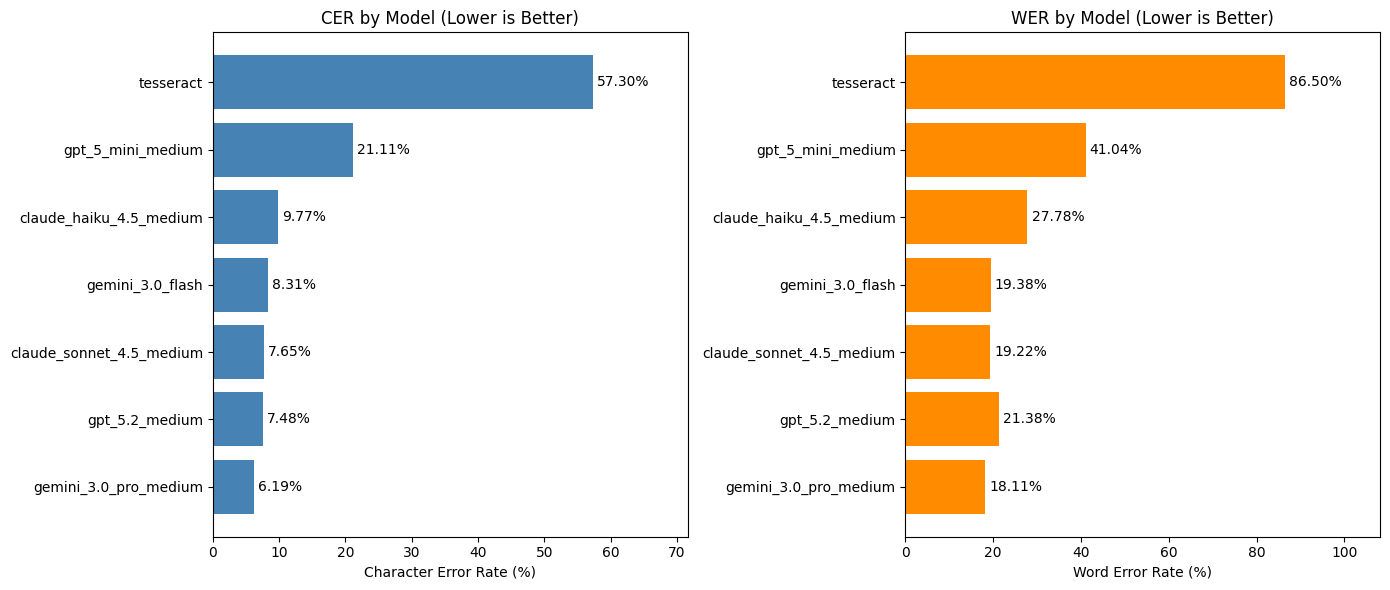

Model,CER (%),WER (%),CER Rank
gemini_3.0_pro_medium,6.19,18.11,1
gpt_5.2_medium,7.48,21.38,2
claude_sonnet_4.5_medium,7.65,19.22,3
gemini_3.0_flash,8.31,19.38,4
claude_haiku_4.5_medium,9.77,27.78,5
gpt_5_mini_medium,21.11,41.04,6
tesseract,57.30,86.50,7


Saved: C:\Users\pagoetz\PycharmProjects\ChronoTranscriber\eval\reports\latex_tables\table_06_performance_summary.tex


In [11]:
# =============================================================================
# 7. Visualization (Optional)
# =============================================================================

try:
    import matplotlib.pyplot as plt
    import numpy as np

    PLOT_AVAILABLE = True
except ImportError:
    PLOT_AVAILABLE = False
    print("matplotlib not available - skipping visualizations")
    print("Install with: pip install matplotlib")

if PLOT_AVAILABLE and overall_model_metrics:
    # Prepare data - sort by CER for consistent ordering
    ranked = sorted(overall_model_metrics.items(), key=lambda x: x[1].cer)
    models = [m[0] for m in ranked]
    cer_values = [m[1].cer * 100 for m in ranked]
    wer_values = [m[1].wer * 100 for m in ranked]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # CER bar chart
    ax1 = axes[0]
    bars1 = ax1.barh(models, cer_values, color='steelblue')
    ax1.set_xlabel('Character Error Rate (%)')
    ax1.set_title('CER by Model (Lower is Better)')
    ax1.bar_label(bars1, fmt='%.2f%%', padding=3)
    ax1.set_xlim(0, max(cer_values) * 1.25 if cer_values else 10)

    # WER bar chart
    ax2 = axes[1]
    bars2 = ax2.barh(models, wer_values, color='darkorange')
    ax2.set_xlabel('Word Error Rate (%)')
    ax2.set_title('WER by Model (Lower is Better)')
    ax2.bar_label(bars2, fmt='%.2f%%', padding=3)
    ax2.set_xlim(0, max(wer_values) * 1.25 if wer_values else 10)

    plt.tight_layout()

    # Save figure
    fig_path = REPORTS_PATH / f"eval_chart_{timestamp}.png"
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"Chart saved: {fig_path}")

    # Also save as PDF for LaTeX inclusion
    if SAVE_TABLES_LATEX:
        pdf_path = LATEX_OUTPUT_DIR / f"figure_01_error_rates.pdf"
        plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
        print(f"PDF chart saved: {pdf_path}")

    plt.show()

    # =============================================================================
    # Create summary statistics table for visualization
    # =============================================================================
    viz_stats = pd.DataFrame({
        'Model': models,
        'CER (%)': [f'{v:.2f}' for v in cer_values],
        'WER (%)': [f'{v:.2f}' for v in wer_values],
        'CER Rank': range(1, len(models) + 1),
    })

    display(HTML('<h4>Table 6: Model Performance Summary (Sorted by CER)</h4>'))
    display(HTML(viz_stats.to_html(index=False)))

    if SAVE_TABLES_LATEX:
        latex_path = LATEX_OUTPUT_DIR / 'table_06_performance_summary.tex'
        viz_stats.to_latex(latex_path, index=False,
                           caption='Model Performance Summary Sorted by Character Error Rate',
                           label='tab:performance_summary')
        print(f'Saved: {latex_path}')

---

## Next Steps

### Ground Truth Workflow

1. **Extract transcriptions for editing**
   ```bash
   python main/prepare_ground_truth.py --extract --input eval/test_data/output/{category}/{model}
   ```

2. **Edit the generated `_editable.txt` files**
   - Each page is marked with `=== page NNN ===`
   - Correct transcription errors directly in the text
   - Use `[NO TRANSCRIBABLE TEXT]` for blank pages
   - Use `[TRANSCRIPTION NOT POSSIBLE]` for illegible pages

3. **Apply corrections to create ground truth**
   ```bash
   python main/prepare_ground_truth.py --apply --input eval/test_data/output/{category}/{model}
   ```

4. **Check ground truth status**
   ```bash
   python main/prepare_ground_truth.py --status
   ```

### Expected Directory Structure
```
eval/
├── test_data/
│   ├── input/                    # Source documents
│   │   ├── address_books/
│   │   ├── bibliography/
│   │   └── military_records/
│   ├── output/                   # Model outputs (JSONL per source)
│   │   └── {category}/
│   │       └── {model_name}/
│   │           └── {source}/
│   │               └── {source}.jsonl
│   └── ground_truth/             # Corrected transcriptions (JSONL)
│       └── {category}/
│           └── {source}.jsonl
└── reports/                      # Generated evaluation reports
```